**Table of contents**<a id='toc0_'></a>    
- 1. [Technical Setup](#toc1_)    
  - 1.1. [Importing Packages](#toc1_1_)    
  - 1.2. [Setting up package management](#toc1_2_)    
  - 1.3. [Setting up themes](#toc1_3_)    
- 2. [Data Understanding](#toc2_)    
  - 2.1. [About the data](#toc2_1_)    
  - 2.2. [Data Collection](#toc2_2_)    
  - 2.3. [Data Overview](#toc2_3_)    
  - 2.4. [Quality Checks](#toc2_4_)    
- 3. [Data Exploration](#toc3_)    
  - 3.1. [Outliers](#toc3_1_)    
  - 3.2. [Exploring Marital_Status](#toc3_2_)    
  - 3.3. [Exploring Education](#toc3_3_)    
- 4. [saving cleaned data](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Technical Setup](#toc0_)

## 1.1. <a id='toc1_1_'></a>[Importing Packages](#toc0_)

### Python

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
%matplotlib inline

from datetime import datetime
import functools
import gc
import pkg_resources
import types
from IPython.display import display, Markdown

# stats packages
import scipy.stats as stats
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn import metrics
from sklearn import preprocessing


#own modules
from src import get_dataframe_summary, dataframe_info

### R (via rpy2)

In [2]:
import os
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.3.1'  

# import rpy2's package module
from rpy2.robjects.packages import importr
from functools import partial
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.ipython import html
html.html_rdataframe=partial(html.html_rdataframe, table_class="docutils")

%load_ext rpy2.ipython

In [3]:
%%R
library(ggplot2)
library(ggstatsplot)
library(tidyverse)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v lubridate 1.9.2     v tibble    3.2.1
v purrr     1.0.1     v tidyr     1.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


You can cite this package as:
     Patil, I. (2021). Visualizations with statistical details: The 'ggstatsplot' approach.
     Journal of Open Source Software, 6(61), 3167, doi:10.21105/joss.03167


## 1.2. <a id='toc1_2_'></a>[Setting up package management](#toc0_)

In [4]:
#package management
def get_imports():
    """ Get a list of packages and versions for README.md

        INPUTS:
        -----------
            None

        OUTPUTS:
        -----------
            list of tuples with package names and tuples
    """
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package,
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. 
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# Get the versions of the root package
# by cross-checking the names of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

In [5]:
requirements

[('matplotlib', '3.7.2'),
 ('numpy', '1.24.0'),
 ('pandas', '2.0.3'),
 ('plotly', '5.15.0'),
 ('rpy2', '3.5.13'),
 ('scikit-learn', '1.3.0'),
 ('scipy', '1.11.1'),
 ('seaborn', '0.12.2')]

## 1.3. <a id='toc1_3_'></a>[Setting up themes](#toc0_)

In [3]:
#defining theme
plt.style.use('dark_background')
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.facecolor'] = '#121212'
plt.rcParams['axes.labelcolor'] = '#F2F2F2'
plt.rcParams['xtick.color'] = '#F2F2F2'
plt.rcParams['ytick.color'] = '#F2F2F2'

---

# 2. <a id='toc2_'></a>[Data Understanding](#toc0_)

## 2.1. <a id='toc2_1_'></a>[About the data](#toc0_)

Link to dataset: https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis

Variables Description:

- **ID**: A unique identifier for each customer. This feature may not contribute to a predictive model.

- **Year_Birth**: The birth year of customers, which can be converted to 'Age'.

- **Education** and **Marital_Status**: Categorical features that may require one-hot encoding.

- **Income**: A continuous feature indicating customer's income, with some missing values that need to be filled.

- **Kidhome** and **Teenhome**: Integer variables indicating the number of children in the household.

- **Dt_Customer**: The joining date of customers, which may need to be converted to 'tenure' or similar measure.

- **Recency**: Indicates how recently a customer made a purchase. Further context is needed for proper interpretation.

- **MntX** and **NumXPurchases**: Represent the amount spent on different categories of products and the number of purchases made through different channels, respectively.

- **AcceptedCmpX**: Binary features indicating whether the customer accepted offers in different campaigns.

- **Complain**: A binary feature indicating if the customer made a complaint recently.

- **Z_CostContact** and **Z_Revenue**: Features with no variance, hence can be removed.

- **Response**: The binary target variable indicating whether a customer accepted the latest offer.

## 2.2. <a id='toc2_2_'></a>[Data Collection](#toc0_)

In [6]:
df_raw = pd.read_csv('data/marketing_campaign.csv', sep='\t')
print(df_raw.shape)

(2240, 29)


## 2.3. <a id='toc2_3_'></a>[Data Overview](#toc0_)

In [6]:
df_raw.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [7]:
cat_cols = df_raw.select_dtypes(include=['object']).columns.tolist()
binary_cols = [col for col in df_raw.columns if df_raw[col].nunique() == 2]
num_cols = [col for col in df_raw.columns if col not in cat_cols and col not in binary_cols]

get_dataframe_summary(df_raw, cat_list=cat_cols,dummy_list=binary_cols)

### DataFrame Overview

- Dataset with 2240 observations and 29 columns

___________________________________


- **Numerical** columns:

,column_name,type,min,max,number NaN,number unique,sample unique
0,ID,int64,0.0,11191.0,0,2240,"[5524, 2174, 4141, 6182, 5324]"
1,Year_Birth,int64,1893.0,1996.0,0,59,"[1957, 1954, 1965, 1984, 1981]"
2,Income,float64,1730.0,666666.0,24,1974,"[58138.0, 46344.0, 71613.0, 26646.0, 58293.0]"
3,Kidhome,int64,0.0,2.0,0,3,"[0, 1, 2]"
4,Teenhome,int64,0.0,2.0,0,3,"[0, 1, 2]"
5,Recency,int64,0.0,99.0,0,100,"[58, 38, 26, 94, 16]"
6,MntWines,int64,0.0,1493.0,0,776,"[635, 11, 426, 173, 520]"
7,MntFruits,int64,0.0,199.0,0,158,"[88, 1, 49, 4, 43]"
8,MntMeatProducts,int64,0.0,1725.0,0,558,"[546, 6, 127, 20, 118]"
9,MntFishProducts,int64,0.0,259.0,0,182,"[172, 2, 111, 10, 46]"


___________________________________


- **Categorical** columns:

,column_name,type,min,max,number NaN,number unique,sample unique
0,Education,object,2n Cycle,PhD,0,5,"[Graduation, PhD, Master, Basic, 2n Cycle]"
1,Marital_Status,object,Absurd,YOLO,0,8,"[Single, Together, Married, Divorced, Widow]"
2,Dt_Customer,object,01-01-2013,31-12-2013,0,663,"[04-09-2012, 08-03-2014, 21-08-2013, 10-02-201..."


___________________________________


- **Dummy** columns:

,column_name,type,min,max,number NaN,number unique,sample unique
0,AcceptedCmp3,int64,0,1,0,2,"[0, 1]"
1,AcceptedCmp4,int64,0,1,0,2,"[0, 1]"
2,AcceptedCmp5,int64,0,1,0,2,"[0, 1]"
3,AcceptedCmp1,int64,0,1,0,2,"[0, 1]"
4,AcceptedCmp2,int64,0,1,0,2,"[0, 1]"
5,Complain,int64,0,1,0,2,"[0, 1]"
6,Response,int64,0,1,0,2,"[1, 0]"


___________________________________


- There are ***19 numerical*** (18x int and 1x float) columns

- There are ***3 categorical*** columns

- There are ***7 dummy*** columns

___________________________________


- There are ***19 numerical*** (18x int and 1x float) columns


- There are ***3 categorical*** columns


- There are ***7 dummy*** columns


- There are ***24 missing values*** in total in the dataset


## 2.4. <a id='toc2_4_'></a>[Quality Checks](#toc0_)

some common criteria for defining invalid values include:


* Values that are not numeric
* Values that are blank or empty
* Values that are repeated
* Values that are inconsistent with other values in the data set





In [8]:
def deep_data_quality_check_numerical(data, cols):
    """
    This function performs deep data quality checks for numerical data.

    Parameters:
    data (pd.DataFrame): The dataset to be checked.
    cols (list): The list of columns to be checked.

    Returns:
    A dictionary containing the results of the data quality checks.
    """

    # Initialize the dictionary to store the results
    results = {}

    for col in cols:
        # Check for missing values
        missing_values = data[col].isnull().sum()

        # Check for duplicate rows
        duplicate_rows = len(data) - len(data.drop_duplicates())

        # Check for outliers using the IQR method
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outlier_index = data[(data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))].dropna(axis=0, how='all').index
        outliers_iqr = len(outlier_index)

        # Check for outliers using the Z-score method
        z_score = abs(stats.zscore(data[col]))
        outlier_index_z = data[col][z_score > 3].dropna(axis=0, how='all').index
        outliers_zscore = len(outlier_index_z)

        # Check for zero variance
        zero_variance = data[col].var() == 0

        # Check for high correlation
        corr_matrix = data[cols].corr()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        high_correlation = [column for column in upper.columns if any(upper[column] > 0.5)]
        high_correlation = len(high_correlation)

        # Create a dictionary of the results for this column
        results[col] = {
            'missing_values': missing_values,
            'duplicate_rows': duplicate_rows,
            'outliers_iqr': outliers_iqr,
            'outliers_zscore': outliers_zscore,
            'zero_variance': zero_variance,
            'high_correlation': high_correlation
        }

    return results

In [9]:
# num_cols = [col for col in df_raw.columns if col not in cat_cols and col not in binary_cols]
results = deep_data_quality_check_numerical(df_raw, num_cols)
pd.DataFrame(results).T

,missing_values,duplicate_rows,outliers_iqr,outliers_zscore,zero_variance,high_correlation
ID,0,0,0,0,False,7
Year_Birth,0,0,3,3,False,7
Income,24,0,8,0,False,7
Kidhome,0,0,0,0,False,7
Teenhome,0,0,0,0,False,7
Recency,0,0,0,0,False,7
MntWines,0,0,35,16,False,7
MntFruits,0,0,227,64,False,7
MntMeatProducts,0,0,175,37,False,7
MntFishProducts,0,0,223,58,False,7


Summary:

1. **missing_values**: Most columns have no missing values (0), except for the "Income" column, which has 24 missing values.

2. **duplicate_rows**: There are no duplicate rows in the dataset for any of the columns (all values are 0).

3. **outliers_iqr**: Several columns have outliers detected using the IQR (Interquartile Range) method. The "MntFruits," "MntMeatProducts," "MntFishProducts," "MntSweetProducts," and "MntGoldProds" columns have a relatively high number of outliers.

4. **outliers_zscore**: Outliers are also detected using the Z-score method. The columns "MntFruits," "MntMeatProducts," "MntFishProducts," "MntSweetProducts," and "MntGoldProds" have a significant number of outliers.

5. **zero_variance**:  The last two columns, "Z_CostContact" and "Z_Revenue," exhibit zero variance, as indicated by the "True" values

6. **high_correlation**: Most columns have a high correlation with other columns (value is 8), except for the "Z_CostContact" and "Z_Revenue" columns, which are labeled as "True." These two columns might not have enough variability to compute correlations effectively.

In light of these findings, steps to improve data quality include addressing the missing values in the "Income" column, investigating and potentially managing outliers in columns with numerous outliers, and considering the relevance of the "Z_CostContact" and "Z_Revenue" columns due to their low variability and limited correlation with other columns. Additionally, during preprocessing, new features were derived, including customer demographics, campaign engagement, and RFM segments for further analysis in the Data Exploration stage.

The details of derived features are as follows:

1. basic features
   - The "Age" of customers has been calculated based on their birth year.
   - The "Customer_Tenure" has been calculated as the number of days between the current date and the date when the customer joined.
   - A "Month_Joined" feature has been created to capture the month in which customers joined.
   - A "Living_With" feature has been derived based on the presence of children and teenagers in the household.
   - An "Is_Parent" feature has been created to indicate whether a customer is a parent.
   - The "Family_Size" has been calculated based on marital status and the presence of children and teenagers.
   - Customer generations have been categorized based on age.
   - A "Total_Accepted_Campaigns" feature has been generated by summing the responses to various marketing campaigns.
   - An "AcceptedAnyCmp" feature indicates whether a customer accepted any marketing campaign.
   - An "Engagement_Rate" feature has been calculated based on the number of accepted campaigns.

2. RFM Features
   - The "Recency" of customers has been calculated as the number of days since they joined.
   - "Total_Purchases" represents the sum of different types of purchases.
   - "Total_Spending" represents the sum of spending on various product categories.
   - "Spend_per_Purchase" calculates the average spending per purchase, handling cases where total spending is zero.
   - RFM scores have been calculated for recency, frequency, and monetary aspects.
   - An "Avg_RFM" score has been derived as the average of the RFM scores.
   - Customers have been segmented into different RFM segments based on their scores.

There are many different ways to define RFM segments, with the number of segments being the most notable difference. Some definitions divide RFM segments into 11, while others use 5 or 6. In this case, we will use the RFM segment definition with 6 segments from Oracle. This is because having too many segments to target can make it difficult to create focused marketing campaigns.

Below are the details for the segment definition

 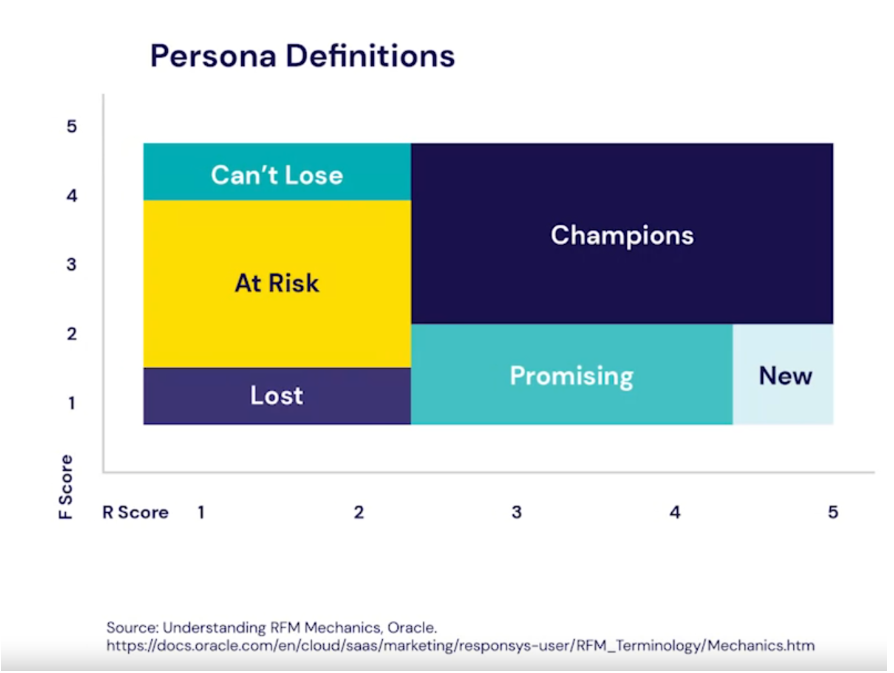  


| RFM Segment | R Score | F Score | Persona Definition |
|---|---|---|---|
| **Champions** | 3, 4, 5 | 3, 4, 5 | Best customers: recent purchase, frequent buyer, high spending |
| **New** | 4, 5 | 1, 2 | Recently acquired customers |
| **Promising** | 3 | 1, 2 | Not recent buyers but have high spending |
| **Can't Lose** | 1, 2 | 3, 4, 5 | Low spending but recent buyers |
| **At Risk** | 1, 2 | 2 | Low spending and not recent buyers |
| **Lost** | 1, 2 | 1 | Customers who have not made a purchase in a long time |

and the following code is the preprocessing and cleaning steps taken

In [10]:
#Initial Data Cleaning and Preprocessing
df = df_raw.copy(deep=True)

#  Missing Values Handling
df['Income'] = df['Income'].fillna(df['Income'].median())

# New Features Derivation
# Calculate Age from Year_Birth
current_year = datetime.now().year
df['Age'] = current_year - df['Year_Birth']
df = df.drop('Year_Birth', axis=1)

# Calculate Customer_Tenure
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
last_recorded_date = df['Dt_Customer'].max()
df['Customer_Tenure'] = (last_recorded_date - df['Dt_Customer']).dt.days
df['Month_Joined'] = df['Dt_Customer'].dt.month

# Create Living_With feature based on Kidhome and Teenhome
conditions = [
    (df['Kidhome'] == 1) & (df['Teenhome'] == 0),
    (df['Kidhome'] == 0) & (df['Teenhome'] == 1),
    (df['Kidhome'] == 1) & (df['Teenhome'] == 1),
]

choices = ['With_Kids', 'With_Teens', 'With_Kids_and_Teens']
df['Living_With'] = np.select(conditions, choices, default='Alone')

# Create Is_Parent feature
df['Is_Parent'] = (df['Kidhome'] + df['Teenhome']).apply(lambda x: 1 if x > 0 else 0)

# Create Family_Size feature
df['Family_Size'] = np.where(
    df['Marital_Status'].isin(['Married', 'Together']),
    df['Kidhome'] + df['Teenhome'] + 1,
    df['Kidhome'] + df['Teenhome']
)

# Define generations
conditions = [
    (df['Age'] >= 76) & (df['Age'] <= 93),
    (df['Age'] >= 57) & (df['Age'] <= 75),
    (df['Age'] >= 41) & (df['Age'] <= 56),
    (df['Age'] >= 25) & (df['Age'] <= 40),
    (df['Age'] >= 9) & (df['Age'] <= 24),
    (df['Age'] >= 0) & (df['Age'] <= 11),
]

choices = ['Silent_Generation', 'Baby_Boomers', 'Generation_X', 'Millennials', 'Generation_Z', 'Generation_Alpha']
df['Generation'] = np.select(conditions, choices, default='Unknown')

# Create Total_Accepted_Campaigns feature
df['Total_Accepted_Campaigns'] = df[['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response']].sum(axis=1)
df['AcceptedAnyCmp'] = df[['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response']].any(axis=1).astype(int)
df['Engagement_Rate'] = (df['Total_Accepted_Campaigns'] / 6) * 100


# Derive RFM features
def rfm_segments(df):
    # Champions
    if df['Recency_Score'] in [3, 4, 5] and df['Frequency_Score'] in [3, 4, 5]:
        return 'Champions'
    # New
    elif df['Recency_Score'] in [4,5] and df['Frequency_Score'] in [1,2]:
        return 'New'
    # Promising
    elif df['Recency_Score'] in [3] and df['Frequency_Score'] in [1,2]:
        return 'Promising'
    #cant lose
    elif df['Recency_Score'] in [1,2] and df['Frequency_Score'] in [3,4,5]:
        return "Can't Lose"
    # At Risk
    elif df['Recency_Score'] in [1,2] and df['Frequency_Score'] in [2]:
        return 'At Risk'
    # Lost
    else:
        return 'Lost'

df['Recency'] = (last_recorded_date - df['Dt_Customer']).dt.days
df['Total_Purchases'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']
df['Total_Spending'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df['Spend_per_Purchase'] = np.where(df['Total_Spending'] == 0, np.nan, df['Total_Spending'] / df['Total_Purchases'])

df['Recency_Score'] = pd.qcut(df['Recency'].rank(method='first'), 5, labels=[5,4,3,2,1]).astype(int)
df['Frequency_Score'] = pd.qcut(df['Total_Purchases'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
df['Monetary_Score'] = pd.qcut(df['Total_Spending'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
df['Avg_RFM'] = (df['Recency_Score'] + df['Frequency_Score'] + df['Monetary_Score'])/3
df['RFM_Segment'] = df.apply(rfm_segments, axis=1)


df = df.drop(['ID', 'Z_CostContact', 'Z_Revenue', 'Dt_Customer'], axis=1)


# 3. <a id='toc3_'></a>[Data Exploration](#toc0_)

In [12]:
plt.style.use('bmh')

## 3.1. <a id='toc3_1_'></a>[Outliers](#toc0_)

To address potential outliers identified in data overview section, a selective approach was employed instead of complete removal. This choice was made because sometimes what is identified as an outlier may actually be a part of the natural distribution of the variable. For example, income data often exhibits heavily skewed distributions, which is natural.

In this situation, outliers were designated as data points significantly distant from the nearest observable data point within the box plot. The goal was not to impose a perfectly normal box plot shape but rather to account for the inherent characteristics of the data. This uniform approach was applied to all variables. Following the outlier treatment, 45 data points, representing approximately 2.01% of the original dataset, were removed.

In [11]:
num_df = df.select_dtypes(include=np.number)
nunique_df = pd.DataFrame(data=num_df.apply(pd.Series.nunique), columns=['nunique']).rename_axis('variables')
selection = nunique_df[nunique_df['nunique'] > 5].index

#plotly frame setup
to_plot = num_df[selection]

# number of variables to plot
num_vars = len(to_plot.columns)

# calculate number of rows and columns for the subplot grid
plot_nrows = int(np.ceil(num_vars / 4))

# create subplot titles
subplot_titles = list(to_plot.columns) + [''] * (plot_nrows * 4 - num_vars)

# create subplots
fig = make_subplots(rows=plot_nrows, cols=4, subplot_titles=tuple(subplot_titles))

# add traces
for i, col_name in enumerate(to_plot.columns):
    row = i // 4 + 1
    col = i % 4 + 1
    fig.add_trace(go.Box(y=to_plot[col_name], name=col_name), row=row, col=col)

fig.update_layout(height=1400, width=1200, showlegend=False, template='plotly_dark', title='Boxplot of Numerical Features')
fig.update_xaxes(visible=False, showticklabels=False)

fig.show()

In [12]:
#Outliers Treatment
#filter multiple conditions
def conjunction(*conditions):
  return functools.reduce(np.logical_and, conditions)

cond1 = df.Age < 90
cond2 = df.Income < 150000
cond3 = df.NumCatalogPurchases < 11
cond4 = df.NumWebVisitsMonth < 13
cond5 = df.NumWebPurchases < 20
cond6 = df.MntSweetProducts < 200
cond7 = df.MntMeatProducts < 1500
cond8 = df.MntGoldProds < 290

df = df[conjunction(cond1, cond2, cond3, cond4, cond5, cond6, cond7, cond8)]
print("Number of data points before outlier removal:", len(df_raw))
print("Number of data points after outlier removal:", len(df))
print("Percentage of data points removed: {:.2f}%".format((len(df_raw) - len(df)) / len(df_raw) * 100))

Number of data points before outlier removal: 2240
Number of data points after outlier removal: 2195
Percentage of data points removed: 2.01%


The distribution of numerical features after treating some potential outliers are as follows

In [55]:
# create subplots
fig = make_subplots(rows=plot_nrows, cols=4, subplot_titles=tuple(subplot_titles))

# add traces
for i, col_name in enumerate(to_plot.columns):
    row = i // 4 + 1
    col = i % 4 + 1
    fig.add_trace(go.Box(y=df[col_name], name=col_name), row=row, col=col)

fig.update_layout(height=1400, width=1200, showlegend=False, template='plotly_dark', title='Boxplot of Numerical Features (Post Outlier Treatment)')
fig.update_xaxes(visible=False, showticklabels=False)

fig.show()

## 3.2. <a id='toc3_2_'></a>[Exploring Marital_Status](#toc0_)

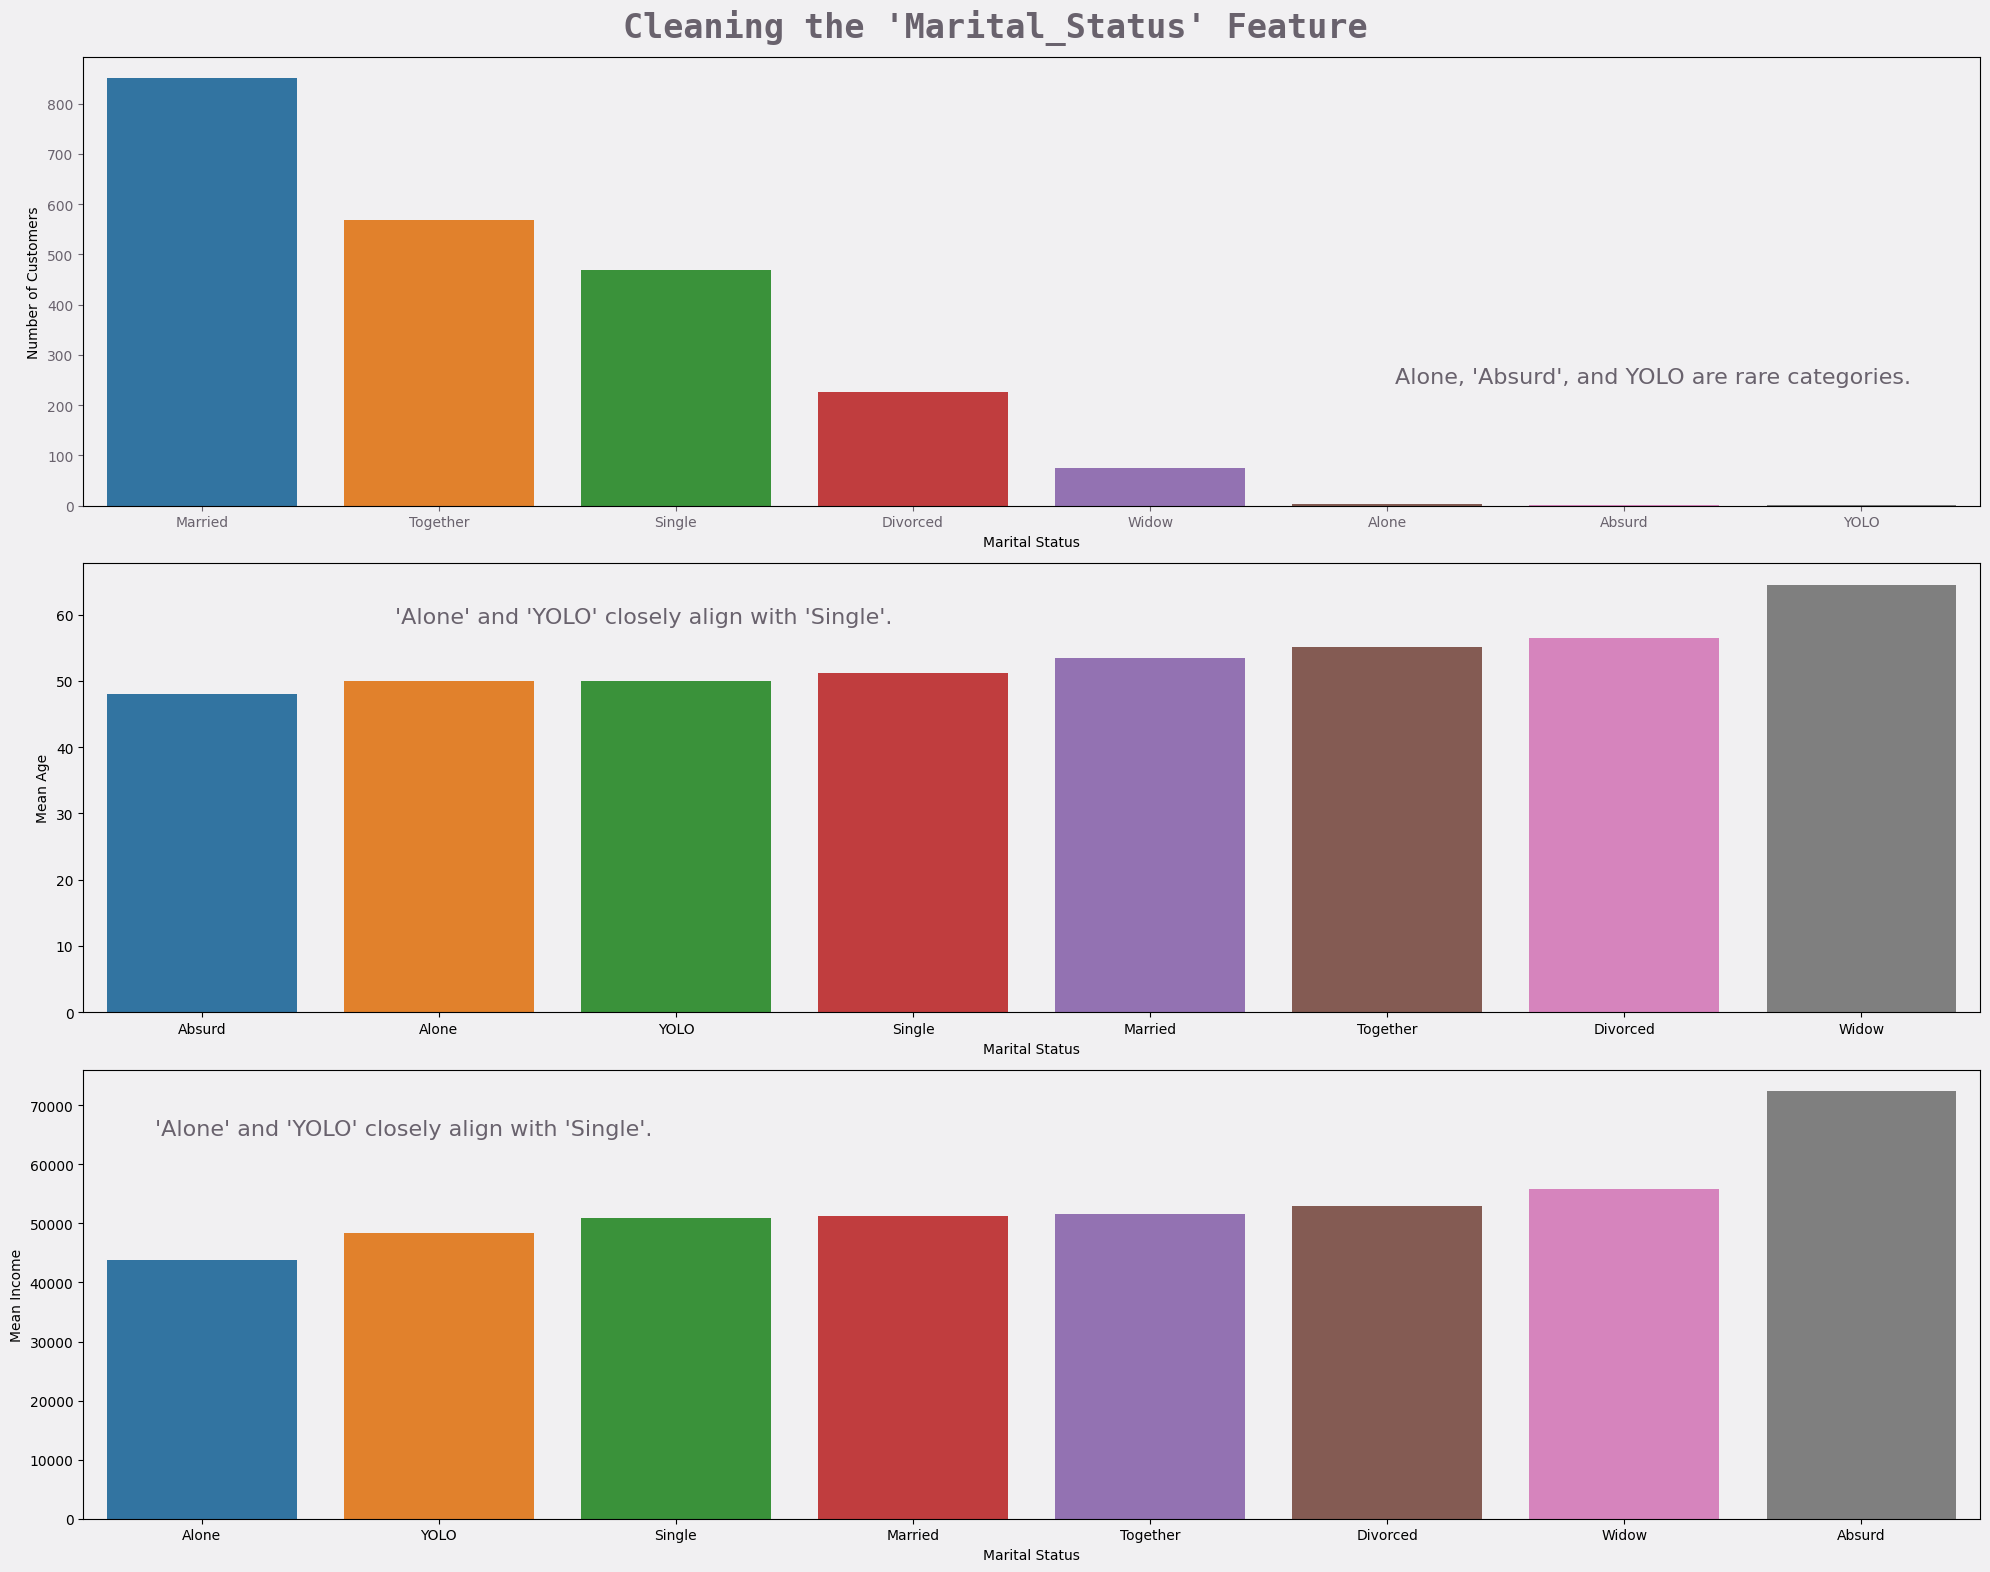

In [56]:
# Plot Marital Features Distribution
# Calculate the order for the Age plot
order_age = df.groupby('Marital_Status')['Age'].mean().sort_values().index

# Calculate the order for the Income plot
order_income = df.groupby('Marital_Status')['Income'].mean().sort_values().index

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 16), facecolor='#F1F0F2')

sns.countplot(x='Marital_Status', data=df, ax=ax1, order=df['Marital_Status'].value_counts().index)
ax1.set_facecolor('#F1F0F2')
ax1.set_xlabel('Marital Status')
ax1.set_ylabel('Number of Customers')
ax1.tick_params(axis='both', colors='#69626D')

# Plot for Age
sns.barplot(x='Marital_Status', y='Age', data=df, estimator=np.mean, ci=None, ax=ax2, order=order_age)
ax2.set_facecolor('#F1F0F2')
ax2.set_ylabel('Mean Age')
ax2.set_xlabel('Marital Status')

# Plot for Income
sns.barplot(x='Marital_Status', y='Income', data=df, estimator=np.mean, ci=None, ax=ax3, order=order_income)
ax3.set_facecolor('#F1F0F2')
ax3.set_ylabel('Mean Income')
ax3.set_xlabel('Marital Status')

# Main title and subtitle
fig.suptitle("Cleaning the 'Marital_Status' Feature", fontsize=24, fontweight='semibold', fontfamily='monospace', color="#69626D")
plt.figtext(0.7, 0.75, "Alone, 'Absurd', and YOLO are rare categories.", ha="left", va="center", fontsize=16, fontfamily='sans-serif', color="#69626D")
plt.figtext(0.2, 0.6, "'Alone' and 'YOLO' closely align with 'Single'.", ha="left", va="center", fontsize=16, fontfamily='sans-serif', color="#69626D")
plt.figtext(0.08, 0.28, "'Alone' and 'YOLO' closely align with 'Single'.", ha="left", va="center", fontsize=16, fontfamily='sans-serif', color="#69626D")

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the space to fit the main title and subtitle
plt.show()

In [14]:
# Merge 'Alone' and 'YOLO' into 'Single'
categories_to_merge = ["Alone", "YOLO"]
df['Marital_Status'] = df['Marital_Status'].replace(categories_to_merge, "Single")

# Remove rows where Marital_Status is 'Absurd'
df = df[df['Marital_Status'] != 'Absurd']

## 3.3. <a id='toc3_3_'></a>[Exploring Education](#toc0_)

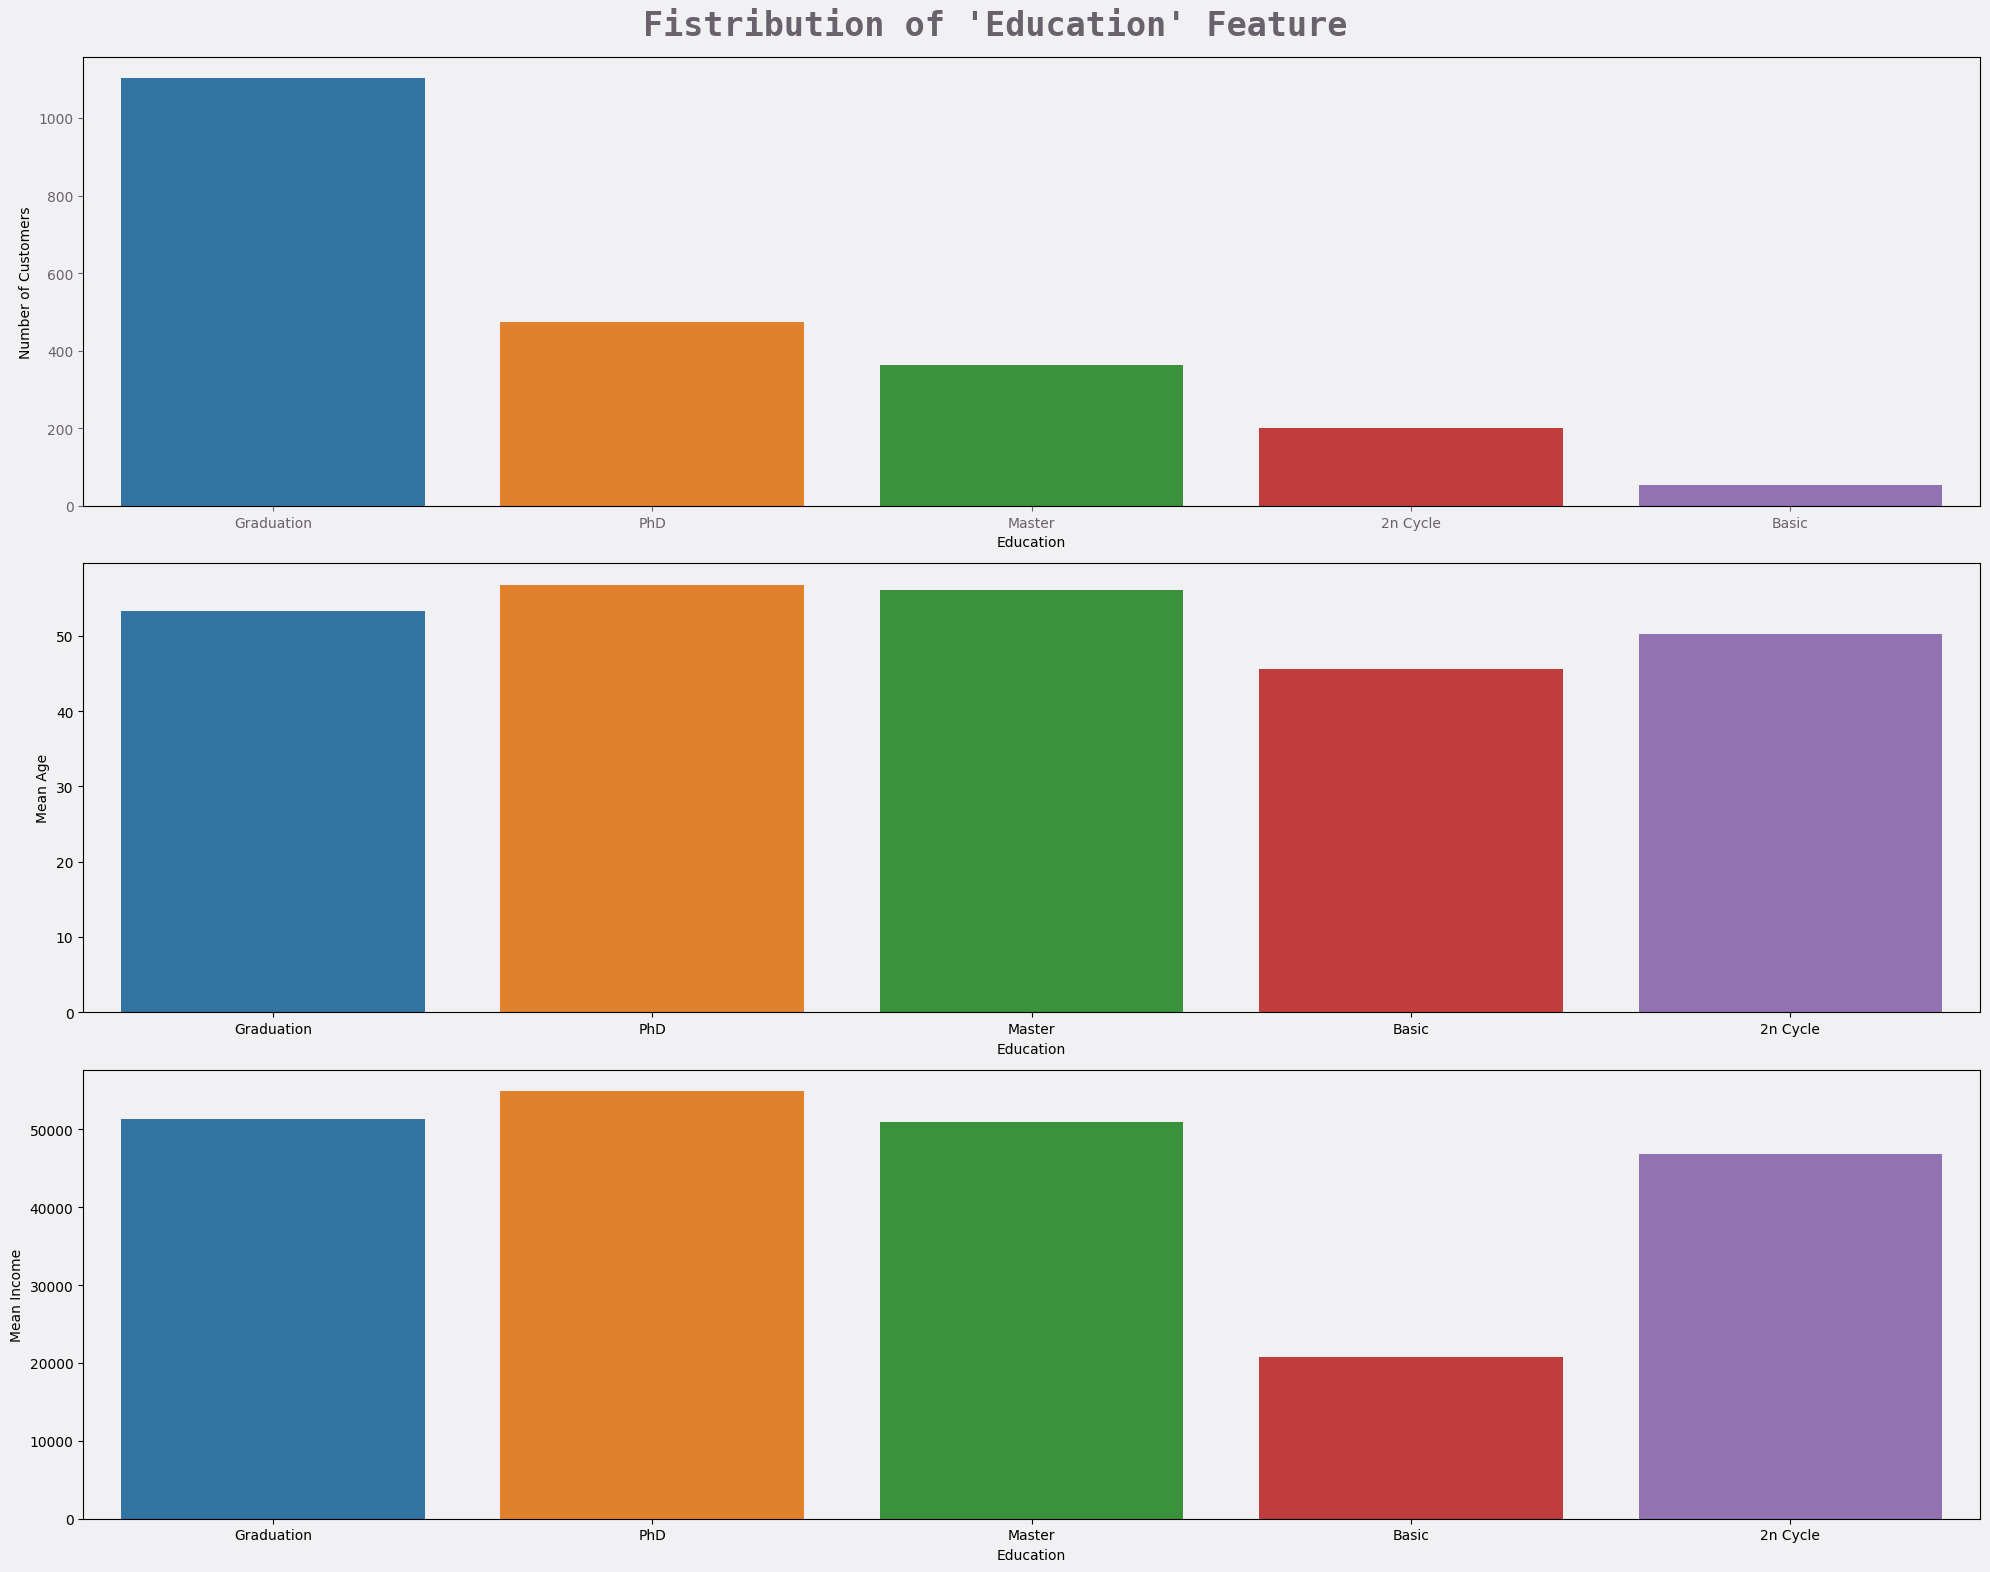

In [58]:
#plot distribution of Education
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 16), facecolor='#F1F0F2')

sns.countplot(x='Education', data=df, ax=ax1, order=df['Education'].value_counts().index)
ax1.set_facecolor('#F1F0F2')
ax1.set_xlabel('Education')
ax1.set_ylabel('Number of Customers')
ax1.tick_params(axis='both', colors='#69626D')

# Plot for Age
sns.barplot(x='Education', y='Age', data=df, estimator=np.mean, ci=None, ax=ax2)
ax2.set_facecolor('#F1F0F2')
ax2.set_ylabel('Mean Age')
ax2.set_xlabel('Education')

# Plot for Income
sns.barplot(x='Education', y='Income', data=df, estimator=np.median, ci=None, ax=ax3)
ax3.set_facecolor('#F1F0F2')
ax3.set_ylabel('Mean Income')
ax3.set_xlabel('Education')

# Main title and subtitle
fig.suptitle("Fistribution of 'Education' Feature", fontsize=24, fontweight='semibold', fontfamily='monospace', color="#69626D")
# plt.figtext(0.7, 0.75, "2n Cycle, Basic, and Graduation are rare categories.", ha="left", va="center", fontsize=16, fontfamily='sans-serif', color="#69626D")
# plt.figtext(0.2, 0.6, "'2n Cycle' and 'Basic' closely align with 'Graduation'.", ha="left", va="center", fontsize=16, fontfamily='sans-serif', color="#69626D")
# plt.figtext(0.08, 0.28, "'2n Cycle' and 'Basic' closely align with 'Graduation'.", ha="left", va="center", fontsize=16, fontfamily='sans-serif', color="#69626D")

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the space to fit the main title and subtitle
plt.show()

# #looking at the median income and age, it seems the ordering of education level is Basic, 2n Cycle, Graduation, Master, then PhD. let's order the chart
# df['Education'] = df['Education'].replace(['2n Cycle', 'Basic', 'Graduation', 'Master', 'PhD'], [1, 2, 3, 4, 5])

- "PhD" and "Master" represent the next two most common education categories, signifying individuals with advanced degrees.
- "2n Cycle" and "Basic" exhibit both the lowest counts and median age and income, respectively.
- Although "Graduation" is the most frequently occurring education category, it's important to note that the specific definition of "Graduation" isn't provided, and it could encompass various types of undergraduate degrees or certifications. However, upon closer examination of its median income and age, it appears to correspond to an educational level between "Master" and "2n Cycle." Therefore, the likely ascending order of education levels is "Basic," "2n Cycle," "Graduation," "Master," "PhD."
- In light of this finding, the default values will be replaced by "High School," "Associate's Degree," "Bachelor's Degree," "Master's Degree," and "Doctorate Degree," respectively in order to increase readability.

In [13]:
# Define a mapping for renaming
education_mapping = {
    'Basic': 'High School',
    '2n Cycle': "Associate's Degree",
    'Graduation': "Bachelor's Degree",
    'Master': "Master's Degree",
    'PhD': "Doctorate Degree"
}

# Use the map function to replace the values
df['Education'] = df['Education'].map(education_mapping)

That's it, all the processing steps along with the reasoning behinds them were discussed. Further exploration will be covered on the EDA and RFM Analysis notebook.

In [15]:
#saving processed and cleaned data 
df.to_csv('data/df_clean.csv', index=False)